In [1]:
import sys
sys.path.append('..')

from olfactory_navigation import Environment, Agent
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test, SimulationHistory
from olfactory_navigation.test_setups import run_all_starts_test

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

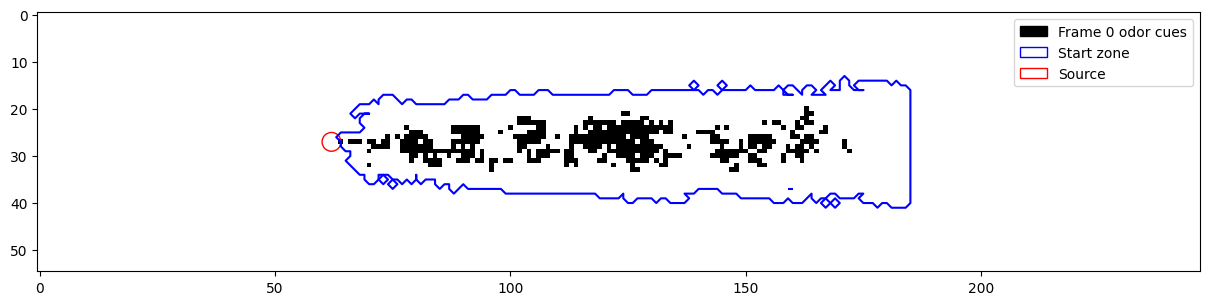

In [3]:
# data_path = "/storage/rando/data/nose_data_27_123.npy" # INSERT YOUR PATH
data_path = "G:\\My Drive\\Documents\\Universita di Genova\\Pimlb work\\nose_data_27_123.npy"

env = Environment(data_file=data_path,
                  data_source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  boundary_condition='wrap_vertical',
                  start_zone='odor_present',
                  odor_present_threshold=3e-6)

env.plot()

In [5]:
from olfactory_navigation.agents.model_based_util.environment_converter import minimal_converter

In [7]:
ag = FSVI_Agent(env, environment_converter=(lambda environment, threshold: minimal_converter(environment=environment, threshold=threshold)))

In [8]:
_ = ag.train(expansions=1000, force=True, use_gpu=True)

[06/18/2024, 10:50:04] MDP_policy, not provided. Solving MDP with Value Iteration...
[06/18/2024, 10:50:04] Sending Model to GPU...
[06/18/2024, 10:50:05]     > Done in 1.176s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 45-state, 4-action
  - Converged in 881 iterations and 3.0124 seconds
  - Took on average 0.0034s per iteration


Expansions:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 45 state, 4 action, 3 observations
  - Converged or stopped after 1000 expansion steps and 1000 backup steps.
  - Resulting value function has 4652 alpha vectors.
  - Converged in 43.3189s

  - Expand function took on average 0.0266s and yielded on average 694.02 beliefs per iteration. (0.0005s/it/belief)
  - Backup function took on average 0.0167s and yielded on average 4.65 alpha vectors per iteration. (0.0003s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


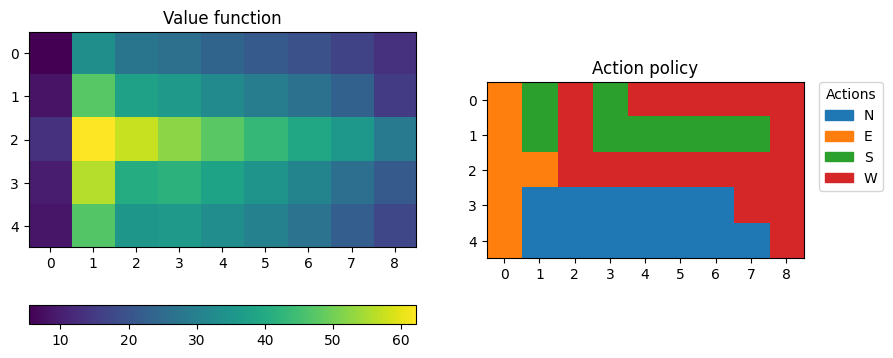

In [9]:
ag.value_function.plot()

In [10]:
hist = run_all_starts_test(ag, use_gpu=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 15.662s:
Simulations reached goal: 1956/2393 (437 failures (reached horizon: 437)) (81.74% success)
 - Average step count:                 314.377 +- 348.66 (Successfull only: 161.199 +- 142.30)
 - Extra steps:                        243.344 +- 326.49 (Successful only: 100.030 +- 133.91)
 - Average discounted rewards (ADR):   0.285 +- 0.27 (Successfull only: 0.349 +- 0.25)
 - Tmin/T:                             0.502 +- 0.35 (Successful only: 0.588 +- 0.33)


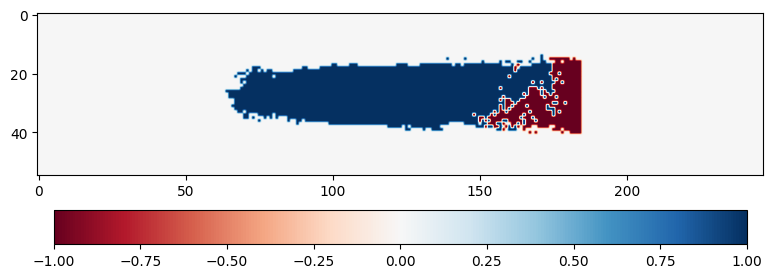

In [11]:
start_points_grid = np.zeros(env.shape)

failed_points = hist.start_points[hist.done_at_step == -1]
success_points = hist.start_points[hist.done_at_step != -1]

start_points_grid[failed_points[:,0], failed_points[:,1]] = -1
start_points_grid[success_points[:,0], success_points[:,1]] = 1

plt.figure(figsize=(10,3))
plt.imshow(start_points_grid, cmap='RdBu')
plt.colorbar(orientation='horizontal')

In [11]:
np.argwhere(hist.done_at_step == -1)[:5]

array([[ 0],
       [ 4],
       [ 7],
       [ 9],
       [10]], dtype=int64)

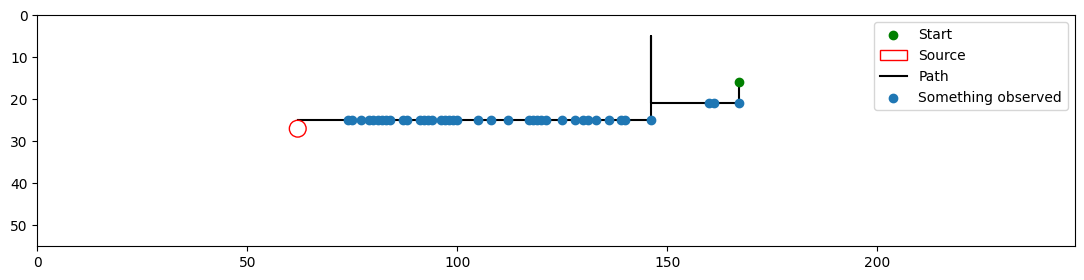

In [26]:
hist.plot(19)